In [1]:
import sys

sys.path.append("..")
import PlotMultiruns as pm
import HiddenWeightHelpers as hw
from pathlib import Path
import numpy as np

/home/mwagner/bin/anaconda3/envs/hcprediction/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


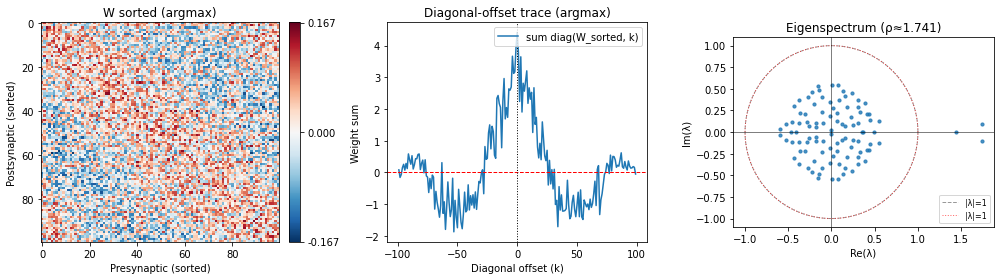

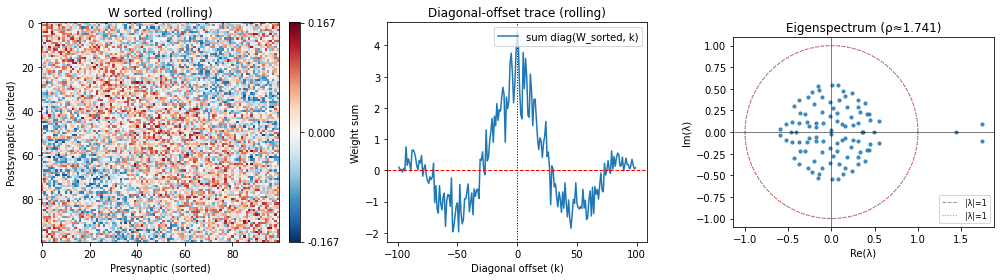

In [2]:
# One combo, single run
MODEL_ROOT = Path("../Elman_SGD/Remap_predloss/N100T100/")

model_path = (
    MODEL_ROOT
    / "baseline"
    / "gaussian"
    / "multiruns"
    / "run_09"
    / "Ns100_SeqN100_predloss_full.pth.tar"
)
# Argmax mode
offsets, trace_vals, sort_idx = pm.weight_trace_single_run(
    model_path, use_rolling=False, plot=True, plot_eigs=True, save=True
)

# Rolling mode
offsets, trace_vals, sort_idx = pm.weight_trace_single_run(
    model_path, use_rolling=True, rolling_window=7, plot=True, plot_eigs=True, save=True
)

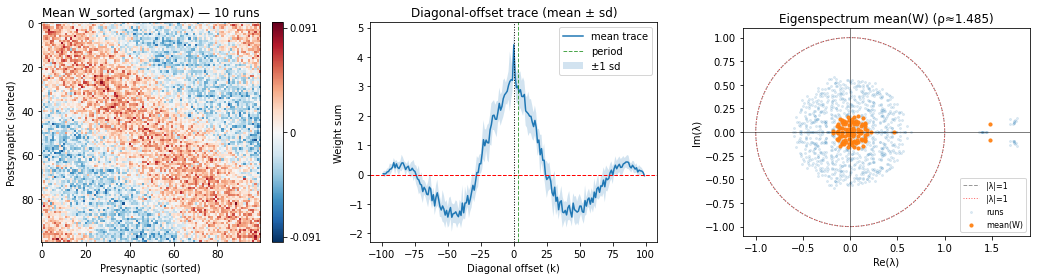

{'period_pixels': 3.0,
 'd_inhib_pixels': None,
 'fwhm_pixels': 18.807168908838875,
 'sigma_est': 7.9860589846449574,
 'peak_amp': 4.412306332588196,
 'beta_like': None}

In [ ]:
# 1) Aggregate real runs and extract summary

# Argmax ordering; plot all three panels; with cloud of per-run eigs
mean_W, summary = pm.weight_trace_mean_across_runs(
    model_path,
    use_rolling=False,
    plot=True,
    save_fig=True,
    save_npy=True,
    plot_trace=True,
    plot_eigs=True,
    show_cloud=True,  # turn off if you only want mean(W) eigenvalues
    rho_ref=1.0,
)
summary

- period_pixels: distance from the central excitatory peak to the next excitatory peak. This if the band spacing of the ridge pattern
- d_inhib_pixels: where the strongest inhibitory trough sits between the center and the first side peak
- fwhm_pixels: Full Width at Half Maximum of the central peak in the diagonal-offset trace. this is the ridge-thickness
- sigma_est: Gaussian sigma estimated from FWHM via sigma = FWHM / 2.355
- peak_amp: heigh of the central excitatory peak in the trace (a scale for the overall strength)
- beta_like: ratio of inhibitory depth to peak height. beta_like = |trough| / peak_amp. Acts like a relative inhibition strength. 

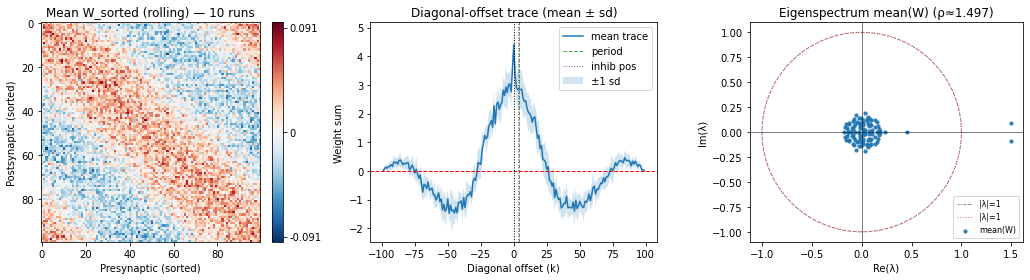

{'period_pixels': 4.0,
 'd_inhib_pixels': 3.0,
 'fwhm_pixels': 20.579853767195257,
 'sigma_est': 8.73879140857548,
 'peak_amp': 4.412306332588196,
 'beta_like': 0.6425977378468313}

In [4]:
# Rolling ordering
mean_W_roll, summary_roll = pm.weight_trace_mean_across_runs(
    model_path,
    use_rolling=True,
    show_cloud=False,
    rho_ref=1.0,
)
summary_roll

In [5]:
def suggest_theory_params_from_summary(summary, *, clip=True):
    """
    Convert `summary` from weight_trace_mean_across_runs into suggested
    parameters for two simple generators:
      (A) Shifted-DoG (excitation at 0, inhibition centered at d0)
      (B) Cosine-carrier with Gaussian envelope
    Prints ready-to-paste lines and returns dicts.
    """
    import math

    # pull with fallbacks
    period = summary.get("period_pixels")
    d_inhib = summary.get("d_inhib_pixels")
    fwhm = summary.get("fwhm_pixels")
    sigma = summary.get("sigma_est")
    peak_amp = summary.get("peak_amp")
    beta_like = summary.get("beta_like")

    # sensible defaults if anything is missing
    if sigma is None and fwhm is not None:
        sigma = fwhm / 2.355
    if sigma is None:
        sigma = 2.0

    # if inhibition location missing, put it mid-gap
    if d_inhib is None and period is not None:
        d_inhib = 0.5 * period
    if d_inhib is None:
        d_inhib = 6.0  # safe default

    # inhibition width: usually broader than excitation
    sigma_e = float(sigma)
    sigma_i = 2.0 * sigma_e

    # inhibition strength
    beta = 0.6 if beta_like is None else float(beta_like)
    if clip:
        beta = max(0.1, min(1.5, beta))

    # cosine params
    if period is None:
        period = 4.0 * sigma_e  # heuristic if spacing wasn’t found
    omega = 2.0 * math.pi / float(period)
    phase = 0.0  # center peak at k=0
    env_sigma = sigma_e
    amp = 1.0 if peak_amp is None else float(peak_amp)

    dog = dict(sigma_e=sigma_e, sigma_i=sigma_i, beta=beta, d0=d_inhib)
    cos = dict(
        period_pixels=float(period),
        omega=omega,
        phase=phase,
        env_sigma=env_sigma,
        amplitude=amp,
    )

    # Pretty print
    print("\n# Suggested params (Shifted DoG)")
    print(f"sigma_e = {sigma_e:.3g}")
    print(f"sigma_i = {sigma_i:.3g}")
    print(f"beta    = {beta:.3g}")
    print(f"d0      = {d_inhib:.3g}  # inhibitory center (pixels)")

    print("\n# Suggested params (Cosine carrier + Gaussian envelope)")
    print(f"period_pixels = {float(period):.3g}  # ridge spacing")
    print(f"omega         = {omega:.4f}          # 2π/period")
    print(f"phase         = {phase:.3g}")
    print(f"env_sigma     = {env_sigma:.3g}")
    print(f"amplitude     = {amp:.3g}")

    return dog, cos

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigvals


def circular_distance_matrix(N: int) -> np.ndarray:
    i = np.arange(N)[:, None]
    j = np.arange(N)[None, :]
    d = np.abs(i - j)
    return np.minimum(d, N - d)  # wrap-around distance on a ring


def build_mexhat_with_gap(
    N=100,
    # --- option A: shifted-lobe DoG ---
    sigma_e=3.0,  # excitatory width
    sigma_i=5.0,  # inhibitory width
    beta=0.7,  # inhibition strength
    d0=12.0,  # distance of inhibitory peaks from the diagonal
    # --- option B: cosine carrier (set use_cosine=True to use this path) ---
    use_cosine=False,
    sigma_carrier=10.0,  # Gaussian envelope width for cosine carrier
    period=24.0,  # band spacing (distance between excitatory ridges)
    # --- common ---
    target_rho=0.95,  # rescale spectral radius
) -> np.ndarray:
    d = circular_distance_matrix(N)

    if not use_cosine:
        # A) explicit gap: inhibitory peaks at ±d0
        ga_e = np.exp(-0.5 * (d / sigma_e) ** 2)
        ga_i1 = np.exp(-0.5 * ((d - d0) / sigma_i) ** 2)
        ga_i2 = np.exp(-0.5 * ((d + d0) / sigma_i) ** 2)
        W = ga_e - 0.5 * beta * (ga_i1 + ga_i2)
    else:
        # B) cosine-modulated Gaussian: inhibition at period/2 automatically
        env = np.exp(-0.5 * (d / sigma_carrier) ** 2)
        W = env * np.cos(2 * np.pi * d / period)

    # rescale spectral radius
    lam_max = float(np.abs(eigvals(W)).max())
    if lam_max > 0:
        W *= target_rho / lam_max
    return W

In [12]:
def W_from_summary(
    summary,
    N,
    method="dog",  # "dog" or "cosine"
    alpha_i=2.0,  # sigma_i = alpha_i * sigma_e (if not in summary)
    target_rho=0.95,
    defaults=None,
):
    """
    Build a theoretical W using parameters extracted by weight_trace_mean_across_runs.

    summary keys expected (if present):
      - "period_pixels" -> desired band spacing (used directly for cosine; implies d0≈period/2 for DoG)
      - "d_inhib_pixels"-> inhibitory offset d0 for DoG-with-gap
      - "sigma_est"     -> excitatory width (pixels) for DoG; fallback: fwhm_pixels/2.355
      - "fwhm_pixels"   -> if sigma_est missing
      - "beta_like"     -> inhibition strength proxy
      - "sigma_i_est"   -> optional explicit inhibitory width

    Returns
      W, used_params_dict
    """
    if defaults is None:
        defaults = {}

    # Pull values with fallbacks
    period = summary.get("period_pixels", defaults.get("period", None))
    d_inhib = summary.get("d_inhib_pixels", defaults.get("d0", None))
    sigma_e = summary.get("sigma_est", defaults.get("sigma_e", None))
    beta = summary.get("beta_like", defaults.get("beta", 0.6))

    # Derive sigma_e from FWHM if needed
    if sigma_e is None:
        fwhm = summary.get("fwhm_pixels", None)
        if fwhm is not None:
            sigma_e = float(fwhm) / 2.355
    if sigma_e is None:
        sigma_e = 2.0  # final fallback

    # Inhibitory width
    sigma_i = summary.get("sigma_i_est", None)
    if sigma_i is None:
        sigma_i = alpha_i * float(sigma_e)

    # Inhibitory offset
    if d_inhib is None and period is not None:
        d_inhib = 0.5 * float(period)
    if d_inhib is None:
        # fallback ~ half of a plausible spacing
        d_inhib = 0.5 * (float(period) if period is not None else 4.0 * float(sigma_e))

    # Clamp beta
    beta = float(max(0.1, min(1.5, float(beta))))

    # Cosine envelope width (optional)
    env_sigma = summary.get("env_sigma", None)
    if env_sigma is None:
        env_sigma = float(sigma_e)

    # Build matrix using your function
    use_cosine = str(method).lower() == "cosine"
    W = build_mexhat_with_gap(
        N=N,
        sigma_e=float(sigma_e),
        sigma_i=float(sigma_i),
        beta=float(beta),
        d0=float(d_inhib),
        use_cosine=use_cosine,
        sigma_carrier=float(env_sigma),
        period=float(period if period is not None else 4.0 * float(sigma_e)),
        target_rho=float(target_rho),
    )

    used = {
        "method": "cosine" if use_cosine else "dog",
        "sigma_e": float(sigma_e),
        "sigma_i": float(sigma_i),
        "beta": float(beta),
        "d0": float(d_inhib),
        "period": float(period if period is not None else 4.0 * float(sigma_e)),
        "target_rho": float(target_rho),
        "env_sigma": float(env_sigma),
    }
    return W, used

In [13]:
# 2) Build a theoretical W that matches those stats (DoG-with-gap)
W_theory, params_used = W_from_summary(summary, N=mean_W.shape[0], method="dog")

print("Used params:", params_used)

# 3) (Optional) Visualize W_theory with the same 3-panel figure you use
#     – you already have this plotting code; just reuse it:
fig = plt.figure(figsize=(12, 4))
ax1 = plt.subplot(1, 3, 1)
cmax = np.max(np.abs(W_theory))
im = ax1.imshow(W_theory, cmap="RdBu_r", vmin=-cmax, vmax=cmax, interpolation="nearest")
ax1.set_title("Theoretical W (from summary)")
plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)

offsets = np.arange(-(W_theory.shape[0] - 1), W_theory.shape[0])
trace_vals = np.array([np.trace(W_theory, offset=k) for k in offsets])
ax2 = plt.subplot(1, 3, 2)
ax2.plot(offsets, trace_vals)
ax2.axhline(0, c="r", ls="--", lw=1)
ax2.axvline(0, c="k", ls=":", lw=1)
ax2.set_title("Diagonal trace (theory)")

lam = eigvals(W_theory)
ax3 = plt.subplot(1, 3, 3)
ax3.scatter(lam.real, lam.imag, s=12, alpha=0.8)
th = np.linspace(0, 2 * np.pi, 512)
ax3.plot(np.cos(th), np.sin(th), "k--", lw=1, alpha=0.5)
ax3.plot(
    params_used["target_rho"] * np.cos(th),
    params_used["target_rho"] * np.sin(th),
    "r:",
    lw=1,
    alpha=0.7,
)
ax3.set_aspect("equal", adjustable="box")
ax3.set_title("Eigenspectrum (theory)")
plt.tight_layout()
plt.show()

TypeError: float() argument must be a string or a number, not 'NoneType'

In [7]:
dog_params, cos_params = suggest_theory_params_from_summary(summary)


# Suggested params (Shifted DoG)
sigma_e = 7.99
sigma_i = 16
beta    = 0.6
d0      = 1.5  # inhibitory center (pixels)

# Suggested params (Cosine carrier + Gaussian envelope)
period_pixels = 3  # ridge spacing
omega         = 2.0944          # 2π/period
phase         = 0
env_sigma     = 7.99
amplitude     = 4.41


In [ ]:
def add_structured_noise(W, noise_std=0.05, smooth_sigma=1.0, seed=0):
    rng = np.random.default_rng(seed)
    noise = rng.standard_normal(W.shape)
    # Gaussian blur kernel
    rad = int(2.5 * smooth_sigma)
    x = np.arange(-rad, rad + 1)
    g = np.exp(-0.5 * (x / smooth_sigma) ** 2)
    g /= g.sum()
    noise = np.apply_along_axis(lambda v: np.convolve(v, g, mode="same"), 0, noise)
    noise = np.apply_along_axis(lambda v: np.convolve(v, g, mode="same"), 1, noise)
    Wn = W + noise_std * np.std(W) * noise
    return Wn